# Modelo de Pairs Trading Baseado em Cointegração

**Autores: Alexandre Fernandes Theoharidis, Débora Darin e Nelly Pires Colnaghi**

O presente código é a implementação de um modelo de pairs trading utilizando cointegração. As principais referências para sua elaboração são XXX. 

\begin{align}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{align}

## Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX # Modelos SARIMA 
import statsmodels.formula.api as smf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from arch.unitroot import DFGLS # teste ADF-GLS
from pykalman import KalmanFilter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction import DictVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

## Configurações

In [2]:
# Comando para que os gráficos sejam exibidos no corpo do texto
%matplotlib inline 

In [3]:
plt.rcParams['figure.dpi'] = 200 # Resolução dos gráficos impressos no pdf (dpi)

In [4]:
# Estilo dos gráficos
sns.set(color_codes = True)

## Parâmetros

In [5]:
# Parâmetros
alfa = 0.01
janela_dados = 126
janela_desloc = 30
janela_update = 20
cost = 0.0025
rf = 0.05

# janela curta -> menos dados -> menos confiança
# janela longa -> não pega variações dos coeficientes ao longo do tempo, ficam muito suavizadas

## Importação e Tratamento dos Dados

In [6]:
# Leitura dos dados

str_dir = 'D:/Estudos/2 Mestrado/Insper/Disciplinas/Finanças Quantitativas/Projeto/'
str_plan_bd_stocks = 'BD_Stocks'

df_prices = pd.read_csv(filepath_or_buffer = str_dir + str_plan_bd_stocks + '.csv', sep=';')
df_prices.index = df_prices['Dates']
df_prices.index = pd.to_datetime(df_prices['Dates'])
df_prices = df_prices.drop(columns=['Dates'])
df_prices = df_prices.dropna()

In [7]:
# Log preços - serão usados nos testes de cointegração
df_log_prices = np.log(df_prices)
df_log_prices.head()

,PETR3 BZ Equity,PETR4 BZ Equity,ITUB4 BZ Equity,BBDC3 BZ Equity,BBDC4 BZ Equity,ITSA4 BZ Equity,BRAP4 BZ Equity,BBAS3 BZ Equity,GOAU4 BZ Equity,GGBR4 BZ Equity,CSNA3 BZ Equity,USIM5 BZ Equity,ELET3 BZ Equity,ELET6 BZ Equity,BRML3 BZ Equity,MULT3 BZ Equity,IGTA3 BZ Equity,TAEE11 BZ Equity,TRPL4 BZ Equity
Dates,,,,,,,,,,,,,,,,,,,
2008-01-01,3.960813,3.788725,2.712573,2.597342,2.693884,1.659180,3.862833,3.414443,3.559596,3.257327,3.268313,3.285075,3.174464,3.132054,2.082811,1.949902,2.674149,2.335343,2.260408
2008-01-02,3.954220,3.772761,2.668061,2.529083,2.621984,1.620180,3.839452,3.394508,3.523739,3.223863,3.251808,3.264002,3.147766,3.136407,2.050656,1.916776,2.631889,2.252659,2.242198
2008-01-03,3.939638,3.756538,2.649008,2.516486,2.601207,1.606835,3.830813,3.379293,3.546826,3.256172,3.272720,3.277673,3.139183,3.125488,2.017832,1.987326,2.619219,2.330492,2.242410
2008-01-04,3.878466,3.706228,2.656055,2.537341,2.589417,1.602212,3.788725,3.367641,3.521111,3.218876,3.240050,3.247580,3.128732,3.118879,1.972830,1.964311,2.613740,2.338628,2.234199
2008-01-07,3.843530,3.676427,2.656055,2.548742,2.609923,1.602212,3.779405,3.391147,3.494111,3.182627,3.206803,3.197938,3.141347,3.136407,1.910875,1.921617,2.628285,2.335343,2.239006


In [8]:
# Cálculo dos retornos
df_returns = df_prices.pct_change()
df_returns = df_returns.iloc[1:,:] # exclui a primeira linha que não possui retornos
df_log_returns = np.log(1+df_returns)
df_log_returns.head()

,PETR3 BZ Equity,PETR4 BZ Equity,ITUB4 BZ Equity,BBDC3 BZ Equity,BBDC4 BZ Equity,ITSA4 BZ Equity,BRAP4 BZ Equity,BBAS3 BZ Equity,GOAU4 BZ Equity,GGBR4 BZ Equity,CSNA3 BZ Equity,USIM5 BZ Equity,ELET3 BZ Equity,ELET6 BZ Equity,BRML3 BZ Equity,MULT3 BZ Equity,IGTA3 BZ Equity,TAEE11 BZ Equity,TRPL4 BZ Equity
Dates,,,,,,,,,,,,,,,,,,,
2008-01-02,-0.006593,-0.015964,-0.044512,-0.068259,-0.071900,-0.039000,-0.023380,-0.019934,-0.035857,-0.033464,-0.016506,-0.021073,-0.026698,0.004353,-0.032155,-0.033127,-0.042260,-0.082683,-0.018210
2008-01-03,-0.014582,-0.016223,-0.019054,-0.012597,-0.020777,-0.013345,-0.008639,-0.015216,0.023087,0.032308,0.020912,0.013671,-0.008583,-0.010919,-0.032824,0.070551,-0.012670,0.077833,0.000212
2008-01-04,-0.061172,-0.050310,0.007047,0.020855,-0.011790,-0.004623,-0.042088,-0.011652,-0.025715,-0.037296,-0.032670,-0.030093,-0.010451,-0.006609,-0.045002,-0.023015,-0.005479,0.008136,-0.008211
2008-01-07,-0.034936,-0.029801,0.000000,0.011401,0.020506,0.000000,-0.009319,0.023506,-0.027001,-0.036249,-0.033247,-0.049642,0.012614,0.017528,-0.061955,-0.042694,0.014546,-0.003285,0.004807
2008-01-08,0.058443,0.053474,0.009227,0.022419,0.015181,0.009024,0.001369,0.020331,-0.007562,0.027208,0.018730,0.034880,0.000864,0.002170,0.009424,0.012076,0.000000,0.000000,-0.010068


## Funções

In [9]:
def KFReg(y, x, delta, obs_cov, init_mean, init_cov, intercept = False, em = False):
    if intercept == True:
        obs_mat = np.vstack([x, np.ones(x.shape)]).T[:, np.newaxis]
        if em == False:
            trans_cov = delta / (1 - delta) * np.eye(2)
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 2, 
                              initial_state_mean = init_mean,
                              initial_state_covariance = init_cov,
                              transition_matrices = np.eye(2), # Essa é a matriz que define o random walk
                              observation_matrices = obs_mat,
                              observation_covariance = obs_cov,
                              transition_covariance = trans_cov)
            state_means, state_covs = kf.filter(y.values)
        else:
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 2, 
                              initial_state_mean = init_mean, 
                              initial_state_covariance = init_cov,
                              observation_matrices = obs_mat)
            state_means, state_covs = kf.filter(y.values)
        beta0 = state_means[:,1]
        beta1 = state_means[:,0]
        resid = y - beta0 - beta1*x
        return beta0, beta1, resid, state_covs, kf
    else:
        obs_mat = np.vstack([x]).T[:, np.newaxis]
        if em == False:
            trans_cov = delta / (1 - delta)
            kf = KalmanFilter(n_dim_obs = 1, 
                              n_dim_state = 1, 
                              initial_state_mean = init_mean,
                              initial_state_covariance = init_cov,
                              transition_matrices = 1,
                              observation_matrices = obs_mat,
                              observation_covariance = obs_cov,
                              transition_covariance = trans_cov)
            state_means, state_covs = kf.filter(y.values)
        else:
            kf = KalmanFilter(n_dim_obs = 1, n_dim_state = 1, 
                              initial_state_mean = init_mean, 
                              initial_state_covariance = init_cov,
                              observation_matrices = obs_mat)
            state_means, state_covs = kf.em(y.values).filter(y.values)
        beta1 = state_means[:,0]
        resid = y - beta1*x
        return beta1, resid, state_covs, kf

### Cálculo do Spread de um Par de Ações

In [10]:
# Função para cálculo do spread
# A variável 'janela' define o tamanho da janela móvel
# A variável 'desloc' define o número de períodos de deslocamento da janela móvel a cada iteração
# Convenção: log_price1 é regredido contra log_price2
# A função retorna, para cada janela móvel:
    # O spread
    # O resultado do teste ADF para verificação da estacionariedade (1 = estacionário)
    # Os coeficientes da regressão: beta0 = intercepto, beta1 = beta do log_price1 contra log_price2

def spread(log_price1, log_price2, janela_dados, janela_desloc):   
    
    y = log_price1
    x = log_price2
    x = sm.add_constant(x)
    T = len(y)
    n = (T-janela_dados)//janela_desloc + 1 # Número de janelas
    
    s = pd.DataFrame(np.NaN, index = y.index, columns = ['Spread'])
    adf_res = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['ADF'])
    johansen_res = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['Johansen'])
    beta0 = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['Beta0'])
    beta1 = pd.DataFrame(np.NaN, index = np.arange(0,n), columns = ['Beta1'])
    
    inicio = 0
    fim = janela_dados
    i = 0
    
    while fim <= T:
        
        results = sm.OLS(y.iloc[np.arange(inicio,fim)], 
                             x.iloc[np.arange(inicio,fim)]).fit()
        beta0.iloc[i,0] = results.params[0]
        beta1.iloc[i,0] = results.params[1]
        s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(results.resid).values
        
        adf_res.iloc[i,0] = 1*(adfuller(x = s.iloc[np.arange(inicio,fim),:], regression = 'c', autolag = 'BIC')[1] < alfa)
        
        
        data = pd.DataFrame(pd.concat([log_price1.iloc[np.arange(inicio,fim)],
                                       log_price2.iloc[np.arange(inicio,fim)]], axis = 1))
        johansen = coint_johansen(endog = data, det_order = 0, k_ar_diff = 1)
        johansen_trace_stat = johansen.lr1[0]
        johansen_trace_crit = johansen.cvt[0][1]
        johansen_res.iloc[i,0] = 1*(johansen_trace_stat > johansen_trace_crit)
        
        inicio = inicio + janela_desloc
        fim = fim + janela_desloc
        i = i + 1
    
    s = s.dropna()
    
    return s, adf_res, johansen_res, beta0, beta1

In [11]:
def spread_KF(log_price1, log_price2, janela_dados, delta, obs_cov, init_mean0, init_cov, intercept = False, em = False):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    s = pd.DataFrame(np.NaN, index = y.index, columns = ['Spread'])
    adf_res = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['ADF'])
    beta0 = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['Beta0'])
    beta1 = pd.DataFrame(np.NaN, index = np.arange(0,T), columns = ['Beta1'])
    
    inicio = 0
    fim = janela_dados
    i = 0
    init_mean = init_mean0
    
    while fim <= T:
        
        x_array = x.iloc[np.arange(inicio,fim)]
        y_array = y.iloc[np.arange(inicio,fim)]
        res = KFReg(y = y_array, x = x_array, 
                    delta = delta, obs_cov = obs_cov, 
                    init_mean = init_mean, init_cov = init_cov, 
                    intercept = intercept, em = em)
        if intercept == False:
            beta1.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[0]).values
            s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[1]).values
            adf_res.iloc[fim-1,0] = 1*(adfuller(x = res[1], 
                                            regression = 'c', 
                                            autolag = 'BIC')[1] < alfa)
        else:
            beta0.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[0]).values
            beta1.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[1]).values
            s.iloc[np.arange(inicio,fim),:] = pd.DataFrame(res[2]).values
            adf_res.iloc[fim-1,0] = 1*(adfuller(x = res[2], 
                                            regression = 'c', 
                                            autolag = 'BIC')[1] < alfa)
        
        inicio = inicio + 1
        if intercept == False:
            init_mean = beta1.iloc[inicio,0]
        else:
            init_mean = np.array([beta1.iloc[inicio,0],
                                    beta0.iloc[inicio,0]])
        fim = fim + 1
        i = i + 1
    
    s = s.dropna()
    
    if intercept == False:
        return s, adf_res, beta1
    else:
        return s, adf_res, beta0, beta1

In [12]:
x = df_log_prices['PETR4 BZ Equity']
x = x.diff()
x[0] = 0
x = x.cumsum()
y = df_log_prices['PETR3 BZ Equity']
y = y.diff()
y[0] = 0
y = y.cumsum()
res = spread_KF(y, x, janela_dados, 
                delta = 1e-2, obs_cov = 0.25, 
                init_mean0 = 1, init_cov = 0.25,
                #init_mean0 = np.array([1,0]), init_cov = np.matrix([[0.25,0],[0,0.25]]), 
                #init_mean0 = np.zeros(2), init_cov = np.ones((2,2)), 
                intercept = False, em = False)

In [13]:
print(res[2])

         Beta1
0     1.000000
1     0.999695
2     0.998974
3     0.998963
4     1.000106
...        ...
3189  1.130271
3190  1.130048
3191  1.131634
3192  1.133314
3193  1.139180

[3194 rows x 1 columns]


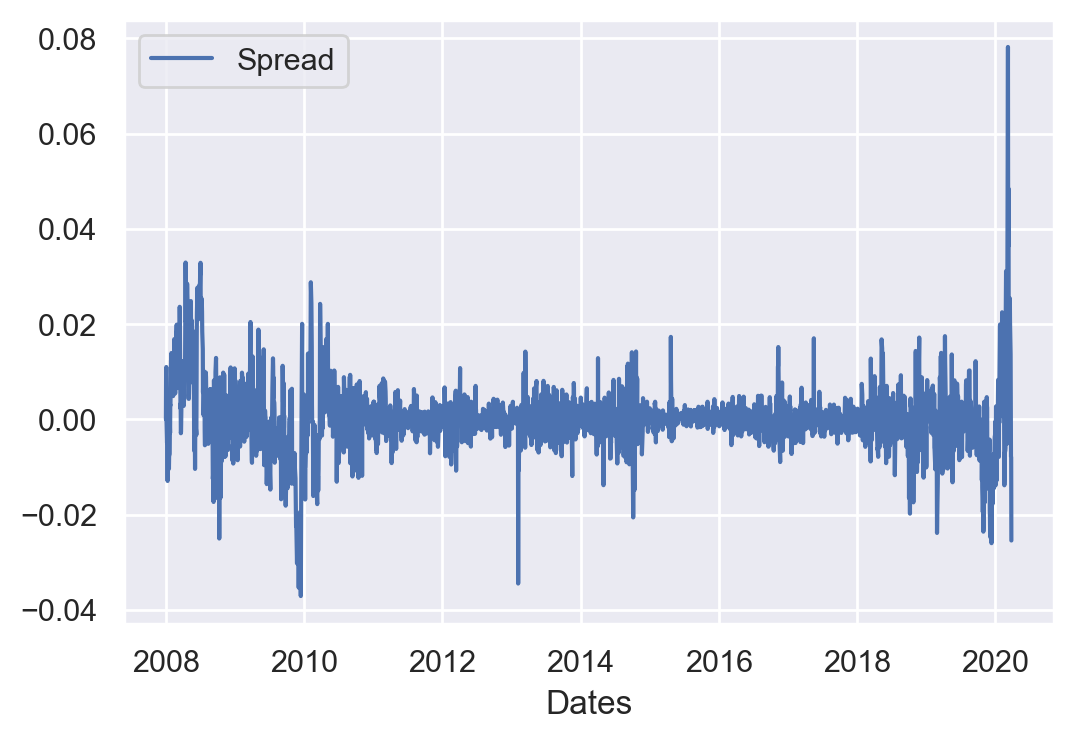

In [14]:
sns.lineplot(data = res[0])

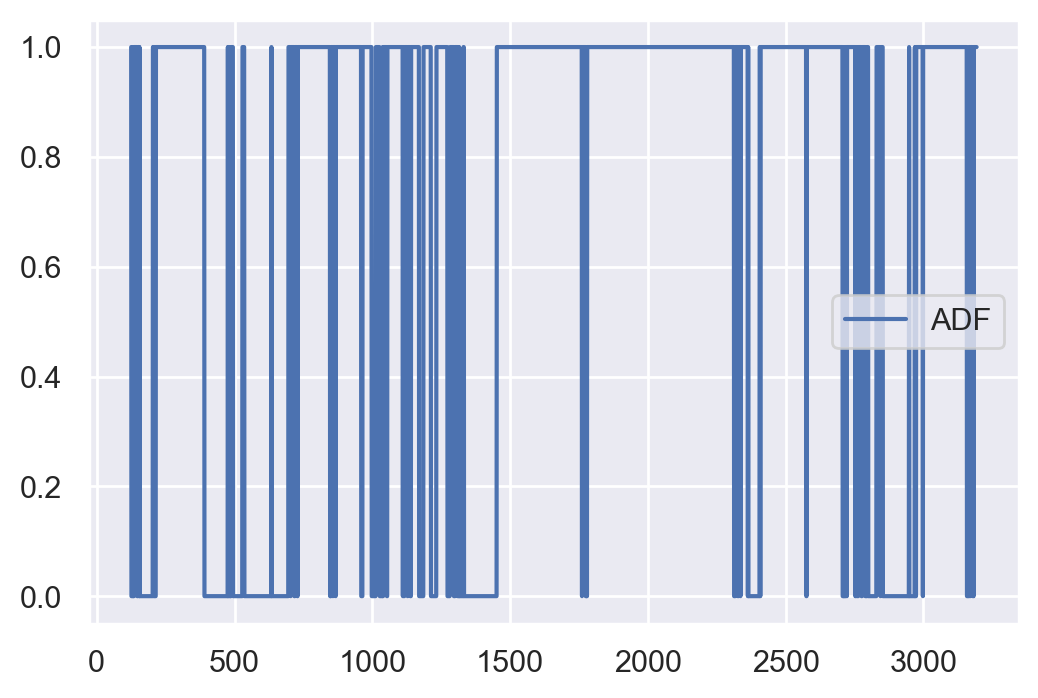

In [15]:
sns.lineplot(data = res[1])

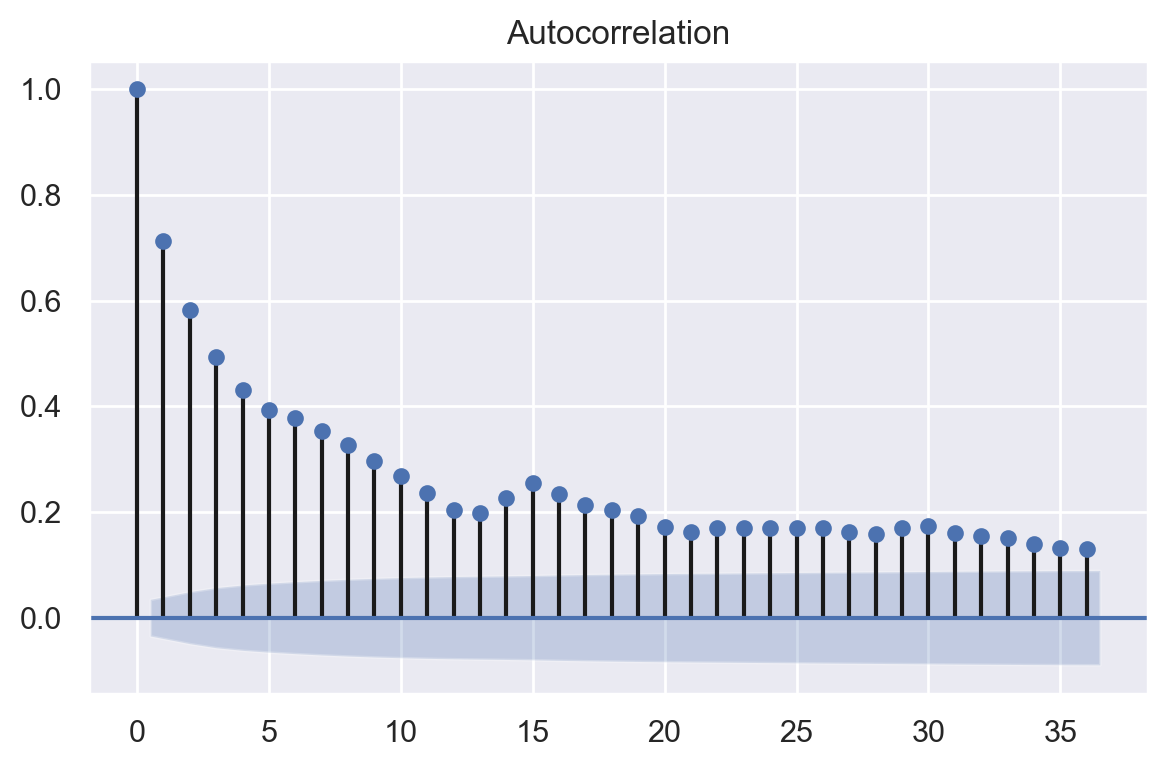

In [16]:
plot_acf(res[0])
plt.tight_layout()

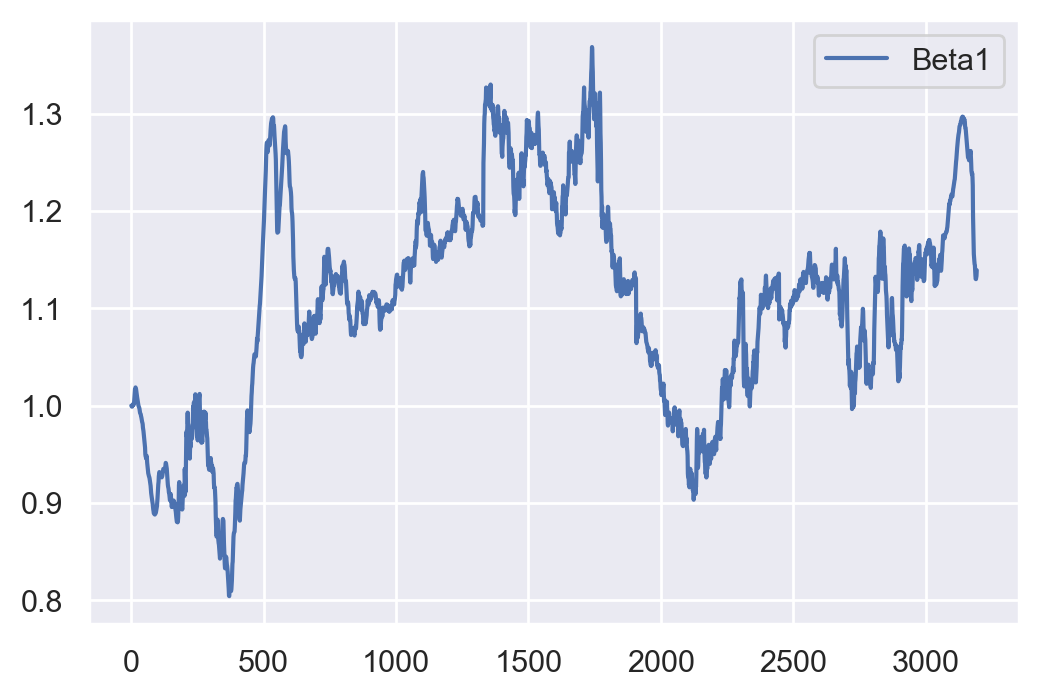

In [17]:
sns.lineplot(data = res[2])

In [211]:
# Função para calcular o threshold ótimo maximizando o retorno da estratégia
# Assume que o spread possui como processo gerador o processo de Ornstein-Uhlenbeck
# O processo é ajustado ao spread discretizado usando um AR(1)

def optimal_threshold(cost, rf, spread):
    spread_cum = np.cumsum(spread)
    arma_order = (1,1,0)
    seasonal_order = (0,0,0,0)
    model = SARIMAX(endog = spread_cum, order = arma_order, seasonal_order = seasonal_order, trend = 'n')
    model_fit = model.fit()
    kappa = model_fit.params[0]
    print(kappa)
    sigma = np.sqrt(model_fit.params[1])
    print(sigma)
    r = lambda th: -kappa*(2*th+cost)/(2*np.pi*sp.special.erfi(th*np.sqrt(kappa)/sigma))
    th0 = 2.5
    res = sp.optimize.minimize(r, th0, method = 'nelder-mead', options={'xatol': 1e-8, 'disp': True})
    return res.x

### Função para Realização do Backtest da Estratégia

In [18]:
# Função para implementação da estratégia e do backtest
# Essa função replica a estratégia de pairs trading com custos de transação
# Os custos são aplicados somente na realização do trade, para fins de simplificação


# Melhorias:
# 1) Considerar uma banda interior
# 2) GARCH sobre o spread para estimar a vol na ponta e projetar para o período seguinte

def backtest(log_price1, log_price2, df_spread, df_beta1, df_coint_res, method, 
             janela_dados, janela_desloc, janela_update, cost, th):
    
    y = log_price1
    x = log_price2
    T = len(y)
    n = (T-janela_dados)//janela_desloc + 1
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    inicio_trade = fim_est 
    fim_trade = fim_est + janela_desloc
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    # -1 se o par foi aberto quando o spread estava na região inferior de fora
    # +1 se o par foi aberto quando o spread estava na região superior de fora
    pos_aberto = -1 
    
    i = 0
    k = 0
    
    while fim_trade <= T:
        
        if df_coint_res.iloc[i,0] == True:
            
            j = 0
            
            for k in np.arange(inicio_trade, fim_trade):
                
                if method == 'OLS':
                    
                    inicio_update = fim_est + j - janela_update
                    fim_update = fim_est + j
                    reg = sm.OLS(y.iloc[np.arange(inicio_update, fim_update)], 
                                     sm.add_constant(x.iloc[np.arange(inicio_update, fim_update)])).fit()
                    beta0 = reg.params[0]
                    beta1 = reg.params[1]
                    avg_spread = np.mean(reg.resid)
                    vol_spread = np.std(reg.resid, ddof = 1)
                    spread_trade = reg.resid[-1]
                
                if method == 'KF':
                    
                    beta1 = df_beta1.iloc[fim_est-1,0]
                    avg_spread = np.mean(s.iloc[np.arange(inicio_est, fim_est)]).values
                    vol_spread = np.std(s.iloc[np.arange(inicio_est, fim_est)], ddof = 1).values
                    spread_trade = s.iloc[fim_est-1].values
                
                lim_sup = avg_spread + th*vol_spread
                lim_inf = avg_spread - th*vol_spread
                
                # Caso 1: spread na parte superior de fora da banda
                if spread_trade > lim_sup:
                    
                    # Caso 1.1: sem posição em aberto --> abre posição
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = 1
                    
                    # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
    
                # Caso 2: spread na parte superior de dentro da banda
                if spread_trade > avg_spread and spread_trade < lim_sup:
                
                    # Caso 2.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) 
                    
                    # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                
                # Caso 3: spread na parte inferior de dentro da banda
                if spread_trade < avg_spread and spread_trade > lim_inf:
                    
                    # Caso 3.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                # Caso 4: spread na parte inferior de fora da banda
                if spread_trade < lim_inf:
        
                    # Caso 4.1: sem posição em aberto --> abre
                    if par_aberto == False:
                        
                        par_aberto = True
                        pos_aberto = -1
                    
                    # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[k,0] = -(y.iloc[k]-y.iloc[k-1]) + beta1*(x.iloc[k]-x.iloc[k-1]) - cost
                        par_aberto = False
                    
                    # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[k,0] = (y.iloc[k]-y.iloc[k-1]) - beta1*(x.iloc[k]-x.iloc[k-1])
                
                j = j + 1
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[k+1,0] = -(y.iloc[k+1]-y.iloc[k]) + beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[k+1,0] = (y.iloc[k+1]-y.iloc[k]) - beta1*(x.iloc[k+1]-x.iloc[k]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + janela_desloc
        fim_est = fim_est + janela_desloc
        inicio_trade = fim_est 
        fim_trade = fim_est + janela_desloc
        i = i + 1
        
    return df_log_retornos

In [52]:
# Função para gerar os retornos diários da estratégia de pairs trading

def retornos_pares(df_spread, df_coint_res, janela_coint):

    T = df_spread.shape[0]
    
    df_retornos = pd.DataFrame(np.nan, index = df_spread.index, columns = ['Retorno'])
    
    for i in np.arange(janela_coint,T-1):
        
        if np.min(df_coint_res.iloc[np.arange(i-janela_coint, i), 0]) == True:
            
            #retorno = np.abs(df_spread.iloc[i,0])
            retorno = 0
            
            for j in np.arange(i+1,T):
                
                retorno = retorno + df_spread.iloc[j,0] - df_spread.iloc[j-1,0]
                
                if df_spread.iloc[i,0] > 0:
                    
                    if df_spread.iloc[j,0] <= 0:
                        
                        break
                        
                if df_spread.iloc[i,0] < 0:
                    
                    if df_spread.iloc[j,0] >= 0:
                        
                        break
                        
                if np.min(df_coint_res.iloc[np.arange(j-janela_coint, j), 0]) == False:
                    
                    break
                        
            h = j - i
            
            df_retornos.iloc[i,0] = retorno/h
    
    df_retornos = df_retornos.dropna()
    
    return df_retornos

In [53]:
s_norm = (res[0] - np.mean(res[0]))/np.std(res[0], ddof=1)
z = retornos_pares(df_spread = s_norm, df_coint_res = res[1], janela_coint = 5)
z.tail()

,Retorno
Dates,
2020-03-20,-1.493991
2020-03-23,-0.708483
2020-03-24,-1.433819
2020-03-25,-5.610288
2020-03-26,-10.915104


In [ ]:
yX = pd.concat([y,X_with_interactions],axis=1,sort=True).dropna()
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(yX.iloc[:,1:], yX.iloc[:,0])
current_market_features = X_with_interactions.iloc[-1].values
prediction = 'bull' if neigh.predict([current_market_features])[0]>0 else 'bear'
prob_0_and_1 = neigh.predict_proba([current_market_features])[0]
probability = prob_0_and_1[0] if prediction == 'bear' else prob_0_and_1[1]
print('KNN is predicting a %s market with prob %s pct' % (prediction,100*probability))

def knn_par(df_spread, df_retorno_par, k):
    
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh_fit = neigh.fit(df_retorno_par, df_spread)
    

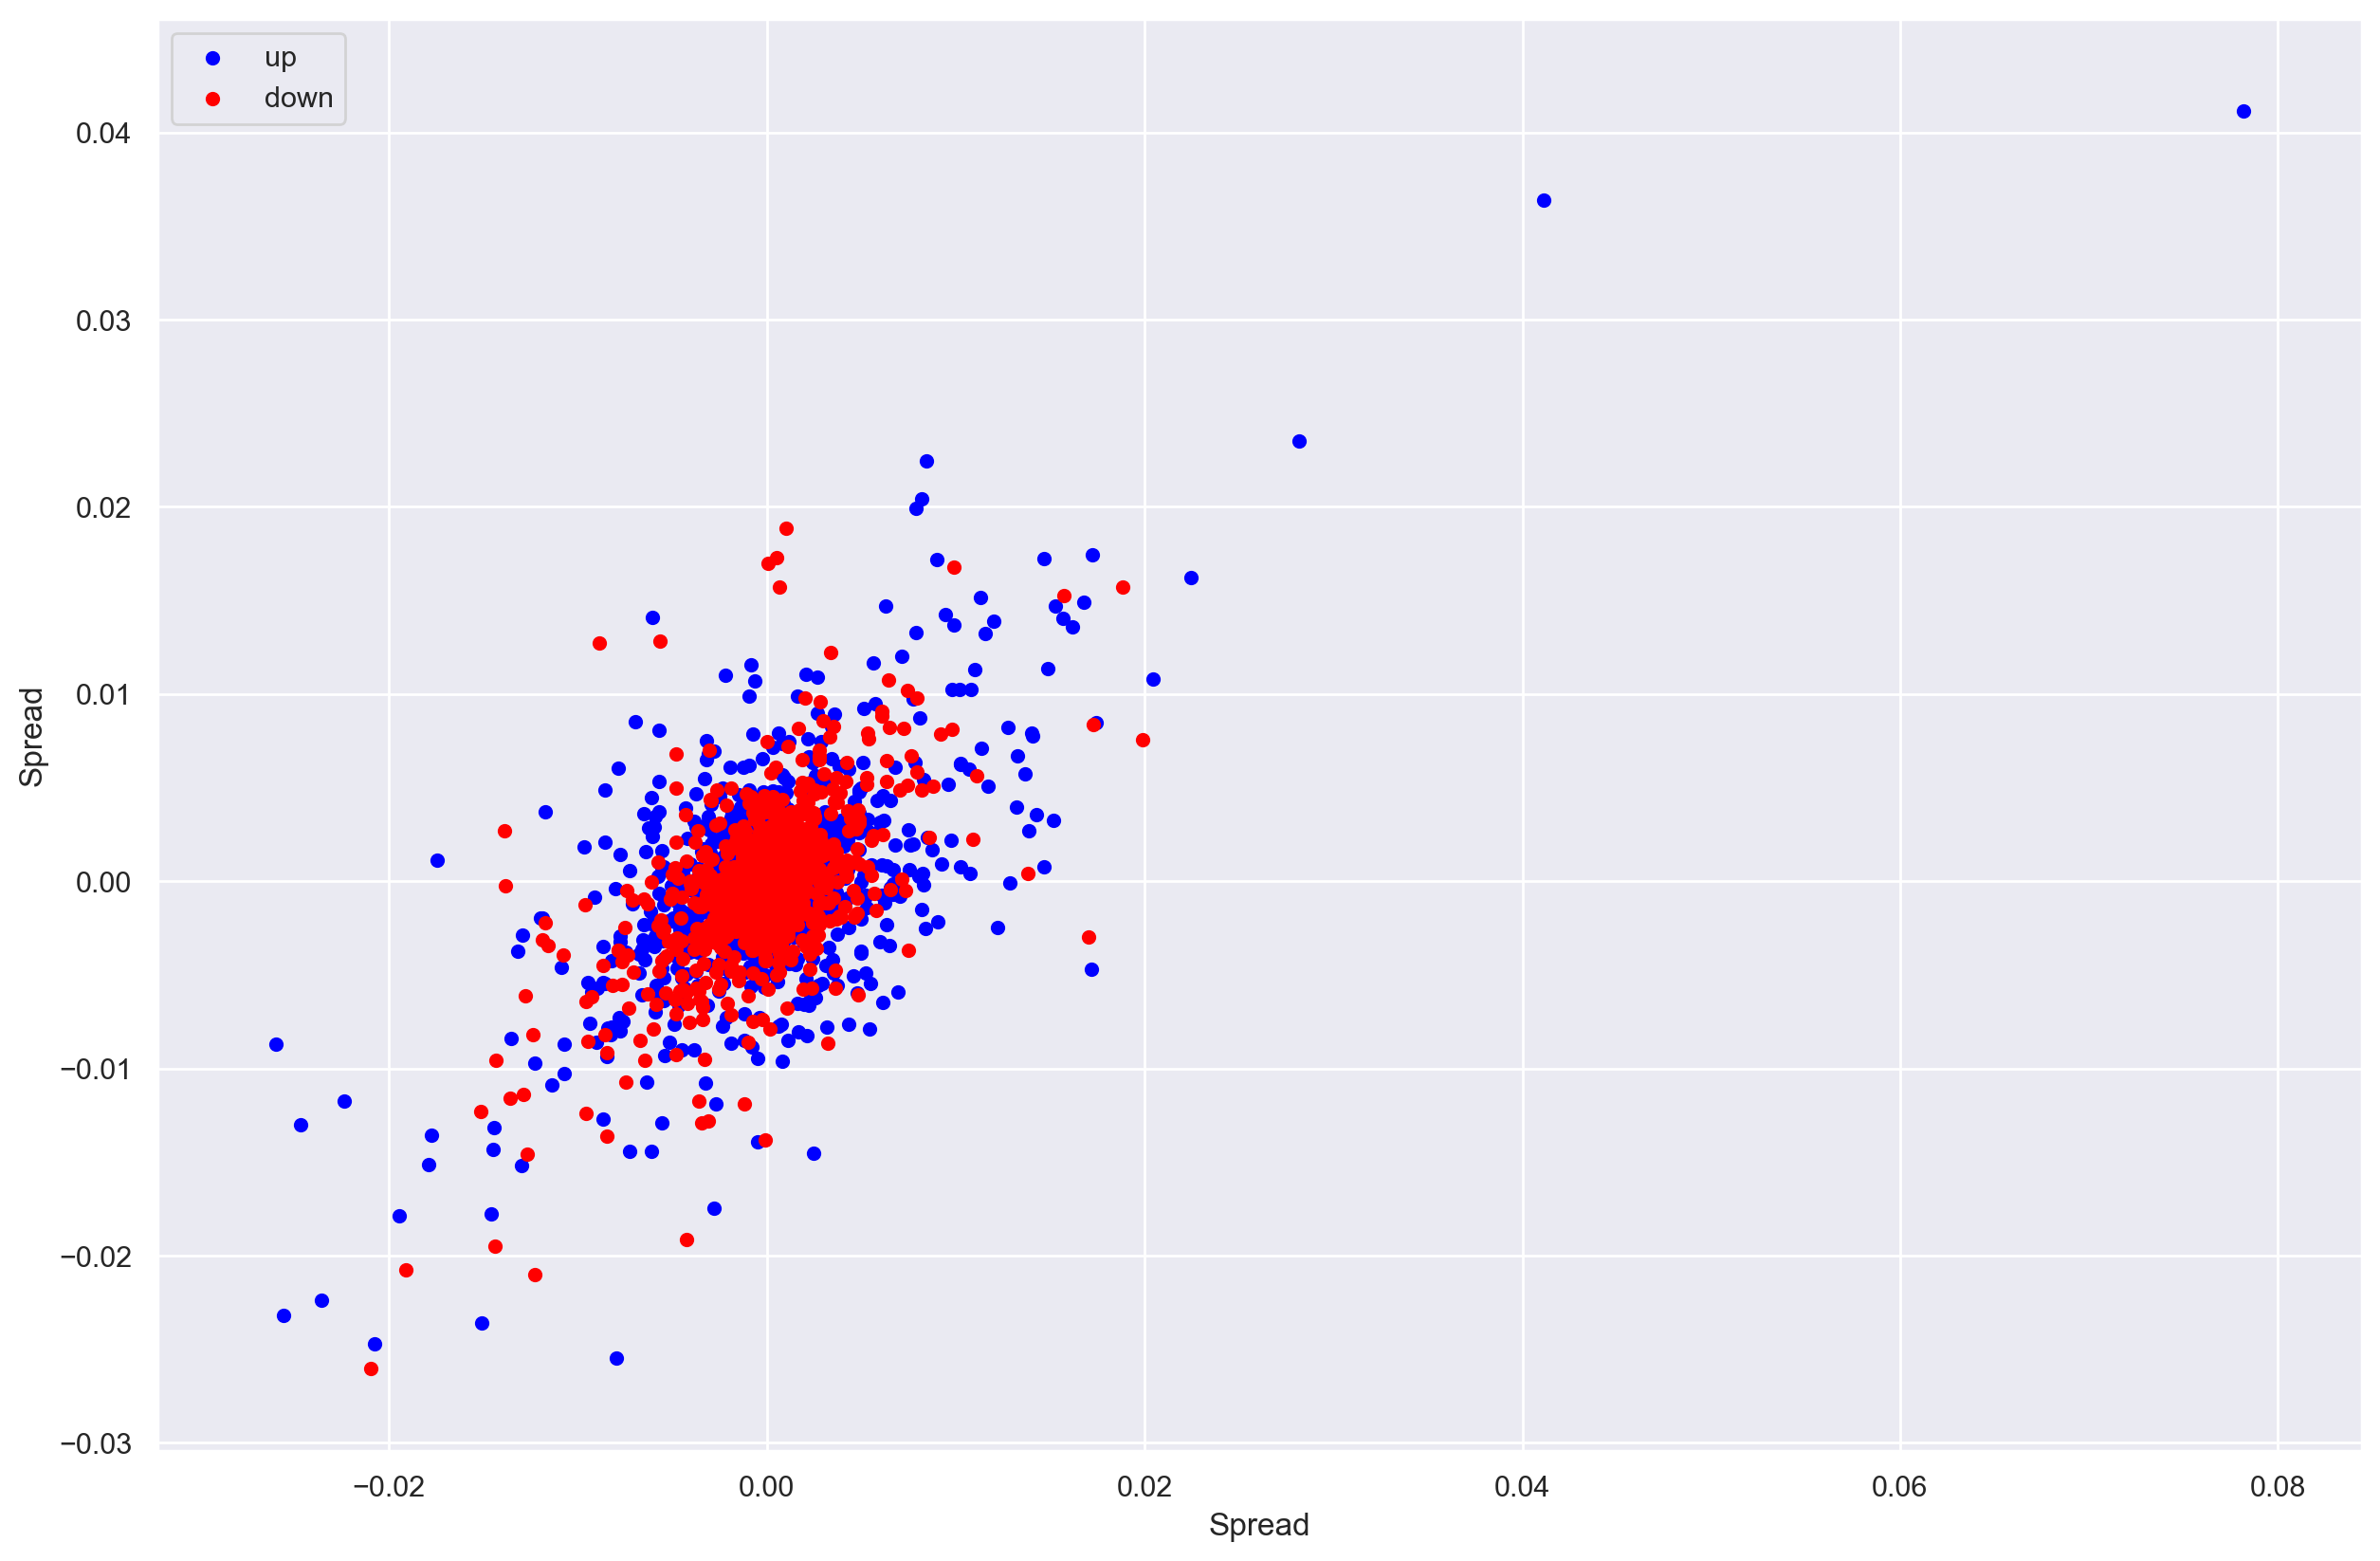

In [188]:
plt.figure(figsize=(15,10))
plot_df = yX[yX.iloc[:,0] == 1]
plt.scatter(plot_df.iloc[:,1], plot_df.iloc[:,2], s = 20, c = 'blue', label = 'up')
plot_df = yX[yX.iloc[:,0] == 0]
plt.scatter(plot_df.iloc[:,1], plot_df.iloc[:,2], s = 20, c = 'red', label = 'down')
plt.legend()
plt.xlabel(plot_df.columns[1])
plt.ylabel(plot_df.columns[2])
plt.show()

In [54]:
k = 20
z_bin = 1*(z>=np.median(z)) # trocar pelo risk free
yX = pd.concat([z_bin, res[0].shift(-1)], join = 'outer', axis = 1).dropna()
neigh = KNeighborsClassifier(n_neighbors=k)
neigh_fit = neigh.fit(yX.iloc[:,1].values.reshape(-1,1),yX.iloc[:,0]) # usar mais valores passsados do spread

In [104]:
neigh_fit

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [145]:
yX.iloc[-1,1]

-0.007996340242047761

In [154]:
print(yX.iloc[np.arange(-1,-10,-1),1])
print(neigh_fit.predict(yX.iloc[np.arange(-1,-10,-1),1].values.reshape(-1,1)))

Dates
2020-03-26   -0.007996
2020-03-25   -0.007794
2020-03-24    0.001052
2020-03-09    0.078181
2020-03-06    0.029903
2020-02-07    0.022471
2020-02-06    0.008470
2020-02-05    0.017433
2020-02-04    0.017237
Name: Spread, dtype: float64
[0. 1. 0. 0. 0. 0. 0. 1. 1.]


In [55]:
i = 0
TP = 0
TN = 0
FP = 0
FN = 0
obs_values = yX.iloc[:,0]
fitted_values = neigh.predict(yX.iloc[:,1:])
for i in np.arange(0, len(fitted_values)):
    
        if fitted_values[i] == 1 and obs_values[i] == 1:
            TP = TP + 1
        
        elif fitted_values[i] == 1 and obs_values[i] == 0:
            FN = FN + 1
        
        elif fitted_values[i] == 0 and obs_values[i] == 1:
            FP = FP + 1
        
        else:
            TN = TN + 1

print(TP)
print(TN)
print(FP)
print(FN)

730
1040
749
438


In [56]:
df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true = obs_values, y_pred = fitted_values), 
                                   index = ['Negative', 'Positive'], 
                                   columns = ['Negative', 'Positive'])
print(df_confusion_matrix)

          Negative  Positive
Negative      1040       438
Positive       749       730


In [57]:
recall = TP / (TP + FN) # true positive rate
accuracy = (TP + TN) / (TP + FP + TN + FN)
precision = TP / (TP + FP)
print(recall)
print(accuracy)
print(precision)

0.625
0.5985796415285762
0.4935767410412441


In [76]:
print(np.mean(z))

Retorno    0.001339
dtype: float64


In [78]:
print(np.median(z))

0.0008124170786334612


In [24]:
# Considerar o efeito sobre o custo do número de trades e ajustes causados por delta_beta_lim

def backtest_KF(log_price1, log_price2, df_spread, df_beta1, df_coint_res, 
                janela_dados, janela_coint, cost, th, delta_beta_lim):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    '''
    -1 se o par foi aberto quando o spread estava na região inferior de fora
    +1 se o par foi aberto quando o spread estava na região superior de fora
    '''
    
    pos_aberto = -1
    beta1_ant = df_beta1.iloc[fim_est-1,0]
    beta1 = df_beta1.iloc[fim_est-1,0]
    
    while fim_est < T:
        
        # Regra: se nos últimos (janela_coint) dias houver cointegração, então o par é negociado
        # inicio = fim_est - janela_coint
        # fim = fim_est - 1
        # tam = (fim_est - 1) - (fim_est - janela_coint) + 1 = janela_coint
        if np.min(df_coint_res.iloc[np.arange(fim_est-janela_coint, fim_est), 0]) == True:
            
            if par_aberto == True:
                delta_beta = df_beta1.iloc[fim_est-1,0] - beta1
                if np.abs(delta_beta) > delta_beta_lim:
                    beta1_ant = beta1
                    beta1 = df_beta1.iloc[fim_est-1,0]
            
            avg_spread = np.mean(s.iloc[np.arange(inicio_est, fim_est)]).values
            vol_spread = np.std(s.iloc[np.arange(inicio_est, fim_est)], ddof = 1).values
            spread_trade = df_spread.iloc[fim_est-1].values
                        
            lim_sup = avg_spread + th*vol_spread
            lim_inf = avg_spread - th*vol_spread
                
            # Caso 1: spread na parte superior de fora da banda
            if spread_trade > lim_sup:
                    
                # Caso 1.1: sem posição em aberto --> abre posição
                if par_aberto == False:
                    
                    beta1 = df_beta1.iloc[fim_est-1,0]
                    par_aberto = True
                    pos_aberto = 1
                    
                # Caso 1.2: com posição em aberto, pela parte superior --> mantém
                if par_aberto == True and pos_aberto == 1:
                    
                    cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                # Caso 1.3: com posição em aberto, pela parte inferior --> fecha
                if par_aberto == True and pos_aberto == -1:
                    
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                    par_aberto = False
    
                # Caso 2: spread na parte superior de dentro da banda
                if spread_trade > avg_spread and spread_trade < lim_sup:
                
                    # Caso 2.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 2.2: com posição em aberto, pela parte superior --> mantém
                    if par_aberto == True and pos_aberto == 1:
                        
                        cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                    # Caso 2.3: com posição em aberto, pela parte inferior --> fecha
                    if par_aberto == True and pos_aberto == -1:
                        
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                        par_aberto = False
                
                # Caso 3: spread na parte inferior de dentro da banda
                if spread_trade < avg_spread and spread_trade > lim_inf:
                    
                    # Caso 3.1: sem posição em aberto --> mantém
                    if par_aberto == False:
                        
                        par_aberto = False
                    
                    # Caso 3.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                        par_aberto = False
                    
                    # Caso 3.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
                # Caso 4: spread na parte inferior de fora da banda
                if spread_trade < lim_inf:
        
                    # Caso 4.1: sem posição em aberto --> abre
                    if par_aberto == False:
                        
                        beta1 = df_beta1.iloc[fim_est-1,0]
                        par_aberto = True
                        pos_aberto = -1
                    
                    # Caso 4.2: com posição em aberto, pela parte superior --> fecha
                    if par_aberto == True and pos_aberto == 1:
                        
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                        par_aberto = False
                    
                    # Caso 4.3: com posição em aberto, pela parte inferior --> mantém
                    if par_aberto == True and pos_aberto == -1:
                        
                        cost_beta = np.abs(beta1 - beta1_ant)*cost/2 
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração
        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost 
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                
                par_aberto = False
                
        inicio_est = inicio_est + 1
        fim_est = fim_est + 1
        
    return df_log_retornos

In [46]:
def backtest_KF_knn(knn_fit, log_price1, log_price2, df_spread, df_beta1, df_coint_res, 
                janela_dados, janela_coint, cost, delta_beta_lim):
    
    y = log_price1
    x = log_price2
    T = len(y)
    
    inicio_est = 0
    fim_est = janela_dados # notar que, pelo uso do np.arange, último dia eh fim_est - 1
    
    df_log_retornos = pd.DataFrame(np.NaN, index = y.index, columns = ['Retornos'])
    
    # Variável que informa se há posição aberta ou não
    par_aberto = False
    
    '''
    -1 se o par foi aberto quando o spread estava na região inferior de fora
    +1 se o par foi aberto quando o spread estava na região superior de fora
    '''
    
    pos_aberto = -1
    beta1_ant = df_beta1.iloc[fim_est-1,0]
    beta1 = df_beta1.iloc[fim_est-1,0]
    
    while fim_est < T:
        
        # Regra: se nos últimos (janela_coint) dias houver cointegração, então o par é negociado
        # inicio = fim_est - janela_coint
        # fim = fim_est - 1
        # tam = (fim_est - 1) - (fim_est - janela_coint) + 1 = janela_coint
        if np.min(df_coint_res.iloc[np.arange(fim_est-janela_coint, fim_est), 0]) == True:
            
            if par_aberto == True:
                delta_beta = df_beta1.iloc[fim_est-1,0] - beta1
                if np.abs(delta_beta) > delta_beta_lim:
                    beta1_ant = beta1
                    beta1 = df_beta1.iloc[fim_est-1,0]
            
            spread_trade = df_spread.iloc[fim_est-1].values
            
            if par_aberto == False:
                
                knn_predict = knn_fit.predict(spread_trade.reshape(-1, 1))
                
                if knn_predict == 1:
                    if spread_trade > 0:
                        pos_aberto = 1
                    else:
                        pos_aberto = -1
                    par_aberto = True
                
            else:
                
                cost_beta = np.abs(beta1 - beta1_ant)*cost/2
                
                if pos_aberto == 1:
                    
                    if spread_trade <= 0:
                        par_aberto = False
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta - cost
                    else:
                        df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                    
                        
                if pos_aberto == -1:
                    
                    if spread_trade >= 0:
                        par_aberto = False
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta - cost
                    else:
                        df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost_beta
                                    
        # Else para contemplar o caso no qual, no período anterior, havia cointegração e foi terminado
        # com posição em aberto, que será fechada imediatamente no período seguinte se não houver cointegração

        else:
            
            if par_aberto == True:
                    
                if pos_aberto == 1:
                        
                    df_log_retornos.iloc[fim_est,0] = -(y.iloc[fim_est]-y.iloc[fim_est-1]) + beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost 
                    
                if pos_aberto == -1:
                
                    df_log_retornos.iloc[fim_est,0] = (y.iloc[fim_est]-y.iloc[fim_est-1]) - beta1*(x.iloc[fim_est]-x.iloc[fim_est-1]) - cost
                
                par_aberto = False
        
        inicio_est = inicio_est + 1
        fim_est = fim_est + 1
        
    return df_log_retornos

In [58]:
ret = backtest_KF_knn(neigh_fit, y, x, s_norm, beta1, adf, 
                janela_dados, 7, 0, 0)

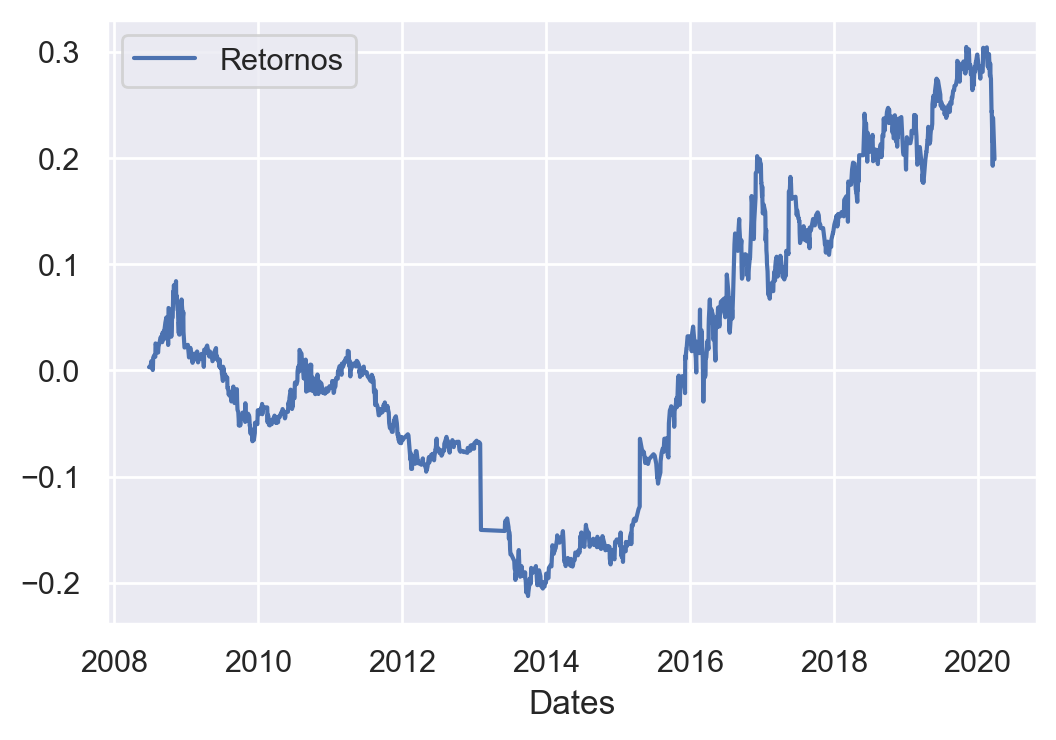

In [59]:
sns.lineplot(data = np.exp(ret.cumsum())-1)

### Funções para Análise de Performance e Risco da Estratégia

Guardar os retornos do portfólio em dataframes com os nomes df_fundo_retorno, df_fundo_retorno_mes e df_fundo_log_retorno

In [81]:
# Função para calcular o Máximo Drawdown
def MaxDD(r_cum):
    x = np.log(1+np.array(r_cum))
    mdd = 0
    pico = x[0]
    i = 0
    dt_inicio_aux = r_cum.index[0]
    for r in x:
        if r > pico:
            pico = r
            dt_inicio_aux = r_cum.index[i]
        dd = (r - pico)
        if dd < mdd:
            mdd = dd
            dt_inicio = dt_inicio_aux
            dt_fim = r_cum.index[i]
        i = i + 1
    return [np.exp(mdd) - 1, dt_inicio, dt_fim]

In [254]:
def Omega(r_port, threshold, num_steps):
    n = len(r_port)
    cols = len(r_port.columns)
    res = pd.DataFrame(np.zeros([1,cols]))
    for j in range(0,cols):
        if not math.isnan(r_port.iloc[0,j]):
            x = r_port.iloc[:,j]
            x = x[:,np.newaxis]
            avg = np.mean(x)
            vol = np.std(x)
            x_plot = np.linspace(-3.5*vol+avg, 3.5*vol+avg, num_steps) # Abrange um intervalo de 3.5 std - pode ajustar
            x_plot_low = x_plot[x_plot<=threshold]
            x_plot_high = x_plot[x_plot>threshold]
            h = 1.06*vol*n**(-1/5) # Silverman's (1986) rule of thumb
            kde = KernelDensity(kernel='gaussian', bandwidth = h).fit(x)
            dens = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
            cum_dens = sp.integrate.cumtrapz(y = dens, x = x_plot, initial = 0)
            try:
                int_low = sp.integrate.simps(cum_dens[x_plot<=threshold], x_plot_low)
                int_high = sp.integrate.simps(cum_dens[x_plot>threshold], x_plot_high)
                res.iloc[0,j]=((np.max(x_plot)-threshold)-int_high)/int_low
            except:
                res.iloc[0,j]=np.nan
    return res

In [ ]:
# Sharpe generalizado
# Preciso checar o artigo original, pois o resultado está estranho para alguns fundos
# Melhor ignorar por enquanto
def ASKSR(r_port, rf, abs_risk_aversion):
    avg = np.mean(r_port)
    var = np.var(r_port)
    skew = sp.stats.skew(r_port)
    kurt = sp.stats.kurtosis(r_port, fisher = False)
    alfa = 3*np.sqrt(3*kurt-4*skew**2-9)/(var*(3*kurt-5*skew**2-9))
    beta = 3*skew/(np.sqrt(var)*(3*kurt-5*skew**2-9))
    eta = avg - 3*skew*np.sqrt(var)/(3*kurt-4*skew**2-9)
    delta = 3*np.sqrt(var)*np.sqrt(3*kurt-5*skew**2-9)/(3*kurt-4*skew**2-9)
    phi = np.sqrt(alfa**2-beta**2)
    a = (1/abs_risk_aversion)*(beta+alfa*(eta-rf)/np.sqrt(delta**2+(eta-rf)**2))
    return np.sqrt(2*(abs_risk_aversion*a*(eta-rf)-delta*(phi-np.sqrt(alfa**2-(beta-abs_risk_aversion*a)**2))))

In [ ]:
# Retornos acima e abaixo do benchmark - Base Diária
if str_tipo_fundo == 'Multimercado':
    df_fundo_retorno_exc = pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_cdi_retorno), index = df_fundo_retorno.index)
    
if str_tipo_fundo == 'Equity':
    df_fundo_retorno_exc = pd.DataFrame(np.array(df_fundo_retorno) - np.array(df_ibov_retorno), index = df_fundo_retorno.index)
    
df_fundo_retorno_exc.columns = ['Fundo_Retorno_Exc']
fundo_pct_retornos_exc_pos = df_fundo_retorno_exc[df_fundo_retorno_exc>0].count() / df_fundo_retorno_exc.count()
fundo_pct_retornos_exc_pos = np.array(fundo_pct_retornos_exc_pos)
fundo_pct_retornos_exc_neg = 1 - fundo_pct_retornos_exc_pos
print('% Retornos Excedentes Positivos:')
print(fundo_pct_retornos_exc_pos)
print('% Retornos Excedentes Negativos:')
print(fundo_pct_retornos_exc_neg)

In [ ]:
# Retornos acima e abaixo do Benchmark - Base Mensal
if str_tipo_fundo == 'Multimercado':
    df_fundo_retorno_exc_mes = pd.DataFrame(np.array(df_fundo_retorno_mes) - np.array(df_cdi_retorno_mes), 
                                        index = df_fundo_retorno_mes.index)

if str_tipo_fundo == 'Equity':
    df_fundo_retorno_exc_mes = pd.DataFrame(np.array(df_fundo_retorno_mes) - np.array(df_ibov_retorno_mes), 
                                        index = df_fundo_retorno_mes.index)

df_fundo_retorno_exc_mes.columns = ['Fundo_Retorno_Exc']
print(df_fundo_retorno_exc_mes)

fundo_pct_retornos_exc_mes_pos = df_fundo_retorno_exc_mes[df_fundo_retorno_exc_mes>0].count() / df_fundo_retorno_exc_mes.count()
fundo_pct_retornos_exc_mes_pos = np.array(fundo_pct_retornos_exc_mes_pos)
fundo_pct_retornos_exc_mes_neg = 1 - fundo_pct_retornos_exc_mes_pos
print('% Retornos Excedentes Positivos:')
print(fundo_pct_retornos_exc_mes_pos)
print('% Retornos Excedentes Negativos:')
print(fundo_pct_retornos_exc_mes_neg)

In [ ]:
# Melhor / Pior Dia
fundo_retorno_min = (np.min(np.array(df_fundo_retorno)))
print("Retorno Diário Mínimo:")
print(fundo_retorno_min)
dia_retorno_min = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_min].index)
print("Data de Ocorrência do Retorno Diário Mínimo:")
print(dia_retorno_min)

fundo_retorno_max = (np.max(np.array(df_fundo_retorno)))
print("Retorno Diário Máximo:")
print(fundo_retorno_max)
dia_retorno_max = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_max].index)
print("Data de Ocorrência do Retorno Diário Máximo:")
print(dia_retorno_max)

In [ ]:
# Melhor / Pior Mês
fundo_retorno_mes_min = (np.min(np.array(df_fundo_retorno_mes)))
print("Retorno Mensal Mínimo:")
print(fundo_retorno_mes_min)
dia_retorno_mes_min = np.array(df_fundo_retorno_mes[df_fundo_retorno_mes['Fundo_Retorno_Mes']==fundo_retorno_mes_min].index)
print("Data de Ocorrência do Retorno Mensal Mínimo:")
print(dia_retorno_mes_min)

fundo_retorno_mes_max = (np.max(np.array(df_fundo_retorno_mes)))
print("Retorno Mensal Máximo:")
print(fundo_retorno_mes_max)
dia_retorno_mes_max = np.array(df_fundo_retorno_mes[df_fundo_retorno_mes['Fundo_Retorno_Mes']==fundo_retorno_mes_max].index)
print("Data de Ocorrência do Retorno Mensal Máximo:")
print(dia_retorno_mes_max)

In [ ]:
# Sharpe para uma janela de 12 meses
fundo_retorno_media_12m = np.mean(np.array(df_fundo_retorno.tail(252)))
cdi_retorno_media_12m = np.mean(np.array(df_cdi_retorno.tail(252)))
fundo_sharpe_12m = (((1+fundo_retorno_media_12m)**252-1) - ((1+cdi_retorno_media_12m)**252-1)) / vol_12m
print("Sharpe nos últimos 12 meses:")
print(fundo_sharpe_12m)

# Sharpe histórico
fundo_retorno_media_hist = np.mean(np.array(df_fundo_retorno))
cdi_retorno_media_hist = np.mean(np.array(df_cdi_retorno))
fundo_sharpe_hist = (((1+fundo_retorno_media_hist)**252-1) - ((1+cdi_retorno_media_hist)**252-1)) / vol_12m
print("Sharpe histórico:")
print(fundo_sharpe_hist)

In [ ]:
# Estilo dos gráficos
sns.set(color_codes = True)

# Gráfico dos retornos acumulados
if str_tipo_fundo == 'Multimercado':
    df_bench_acum = df_cdi_retorno_acum

if str_tipo_fundo == 'Equity':
    df_bench_acum = df_ibov_retorno_acum    
    
df_retornos = pd.merge(df_fundo_retorno_acum, df_bench_acum, 
                    left_index = True, right_index = True, how = 'inner')
df_retornos.columns = [str_plan_fundo_teste, "Benchmark"]
ax = sns.lineplot(data = df_retornos)
ax.set_ylabel("Retorno Acumulado")
ax.set_title("Retornos Acumulados Desde o Início do Fundo")

In [ ]:
# Volatilidade em janelas móveis de 3 meses
du = 63
vol = df_fundo_log_retorno.rolling(du).std(ddof=1)*np.sqrt(252)
vol.columns = [str_plan_fundo_teste]
vol["Media_Hist"] = np.repeat(vol_hist, vol.shape[0])
ax = sns.lineplot(data = vol)
ax.set_ylabel("Volatilidade Anualizada")
ax.set_title("Volatilidade em Janelas de " + str(du) + " d.u.")

## Testes

In [31]:
x = df_log_prices['PETR4 BZ Equity']
x = x.diff()
x[0] = 0
x = x.cumsum()
y = df_log_prices['PETR3 BZ Equity']
y = y.diff()
y[0] = 0
y = y.cumsum()
res = spread_KF(y, x, janela_dados,
                delta = 1e-2, obs_cov = 0.25, 
                #init_mean0 = 1, init_cov = 0.25,
                init_mean0 = np.array([1,0]), init_cov = np.matrix([[0.25,0],[0,0.25]]), 
                #init_mean0 = np.zeros(2), init_cov = np.ones((2,2)), 
                intercept = True, em = False)

IndexError: tuple index out of range

In [32]:
s = res[0]
adf = res[1]
beta1 = res[3]

In [42]:
log_price1 = df_log_prices['PETR3 BZ Equity']
log_price2 = df_log_prices['PETR4 BZ Equity']
s = res[0]
adf = res[1]
beta1 = res[3]
log_retornos1 = backtest_KF(log_price1, log_price2, s, beta1, adf, janela_dados, 10, 0, th = 1, delta_beta_lim = 0.0)
log_retornos2 = backtest_KF(log_price1, log_price2, s, beta1, adf, janela_dados, 10, 0, th = 1, delta_beta_lim = 0.3)

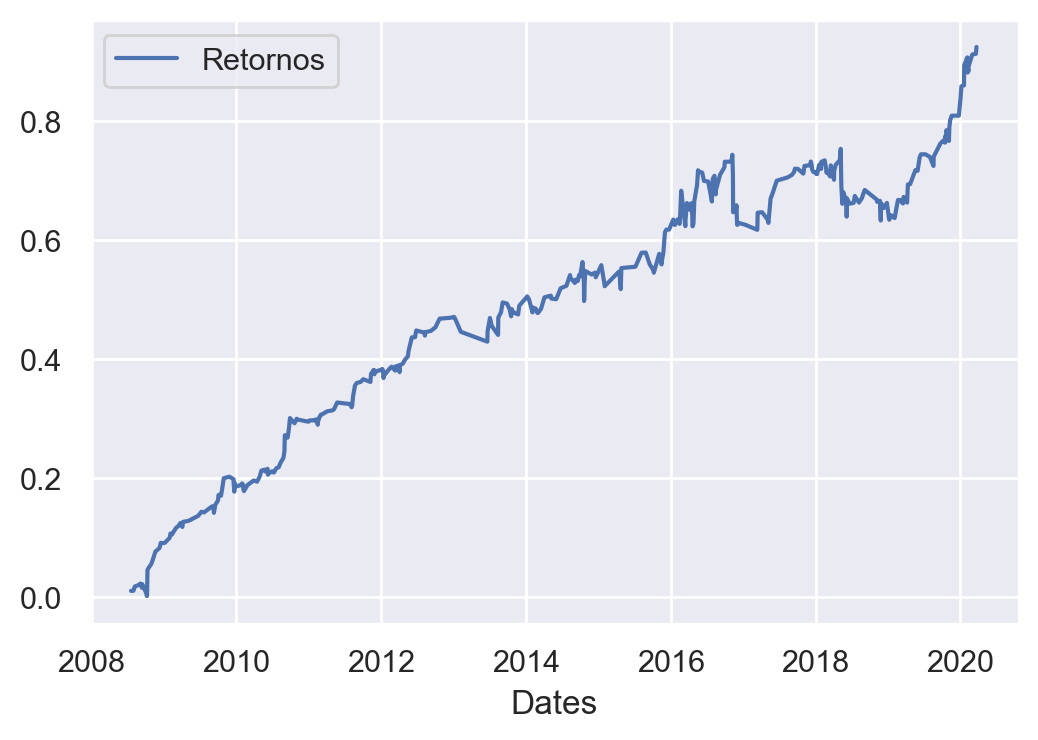

In [43]:
sns.lineplot(data = np.exp(log_retornos1.cumsum())-1)

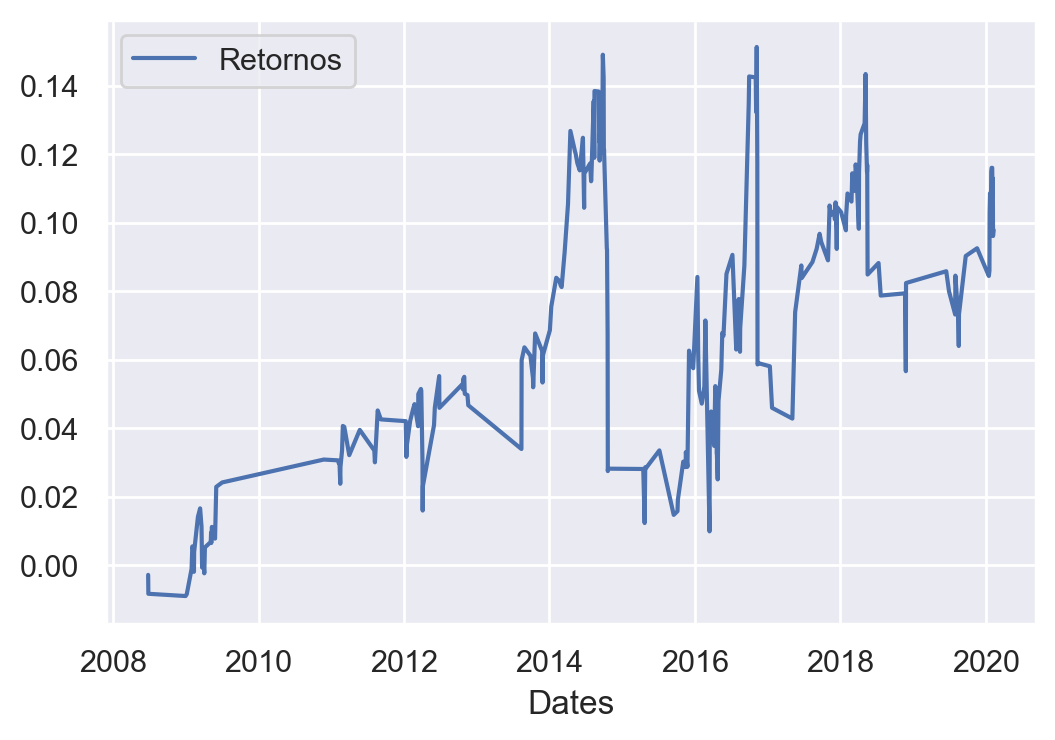

In [125]:
sns.lineplot(data = np.exp(log_retornos2.cumsum())-1)

In [109]:
print(log_retornos1.tail(10))
print(log_retornos2.tail(10))

            Retornos
Dates               
2020-03-16       NaN
2020-03-17       NaN
2020-03-18       NaN
2020-03-19       NaN
2020-03-20       NaN
2020-03-23       NaN
2020-03-24       NaN
2020-03-25       NaN
2020-03-26       NaN
2020-03-27       NaN
            Retornos
Dates               
2020-03-16       NaN
2020-03-17       NaN
2020-03-18       NaN
2020-03-19       NaN
2020-03-20       NaN
2020-03-23       NaN
2020-03-24       NaN
2020-03-25       NaN
2020-03-26       NaN
2020-03-27       NaN


In [87]:
print(len(log_retornos.dropna())/len(log_retornos))

0.07858484658735128


In [77]:
log_retornos.head()

,Retornos
Dates,
2008-01-01,NaN
2008-01-02,NaN
2008-01-03,NaN
2008-01-04,NaN
2008-01-07,NaN


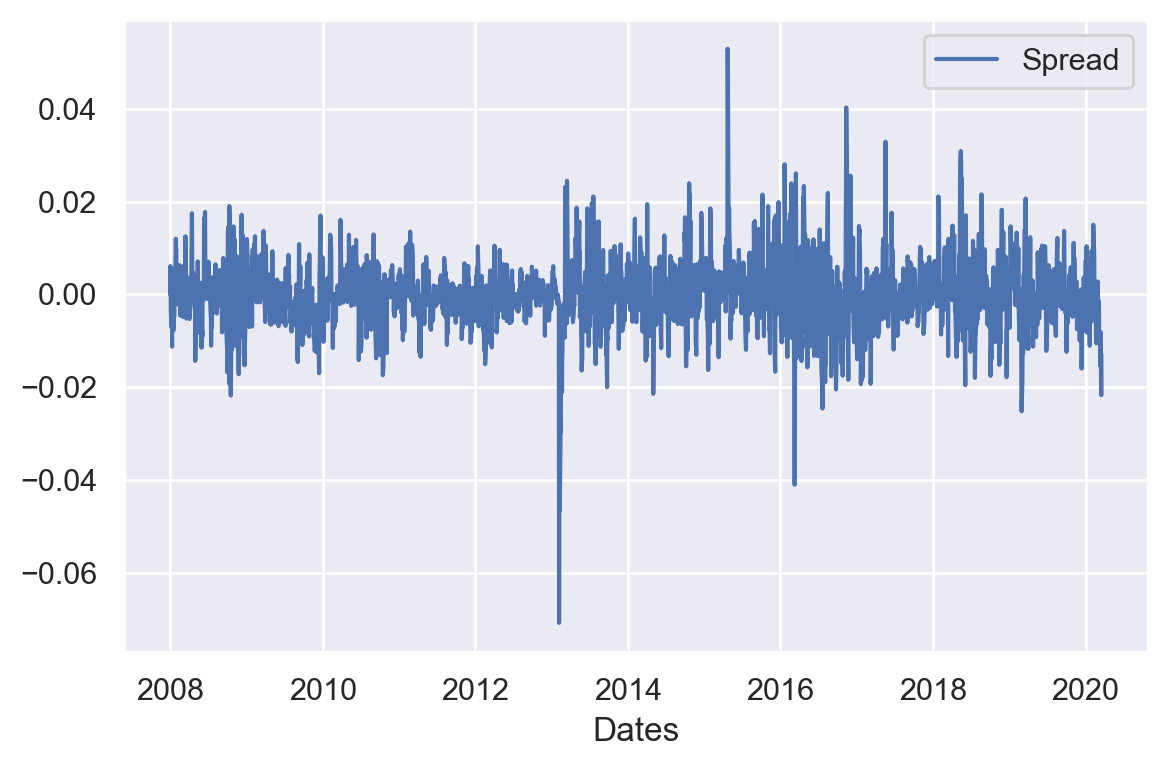

In [183]:
ax = sns.lineplot(data = s)
plt.tight_layout()

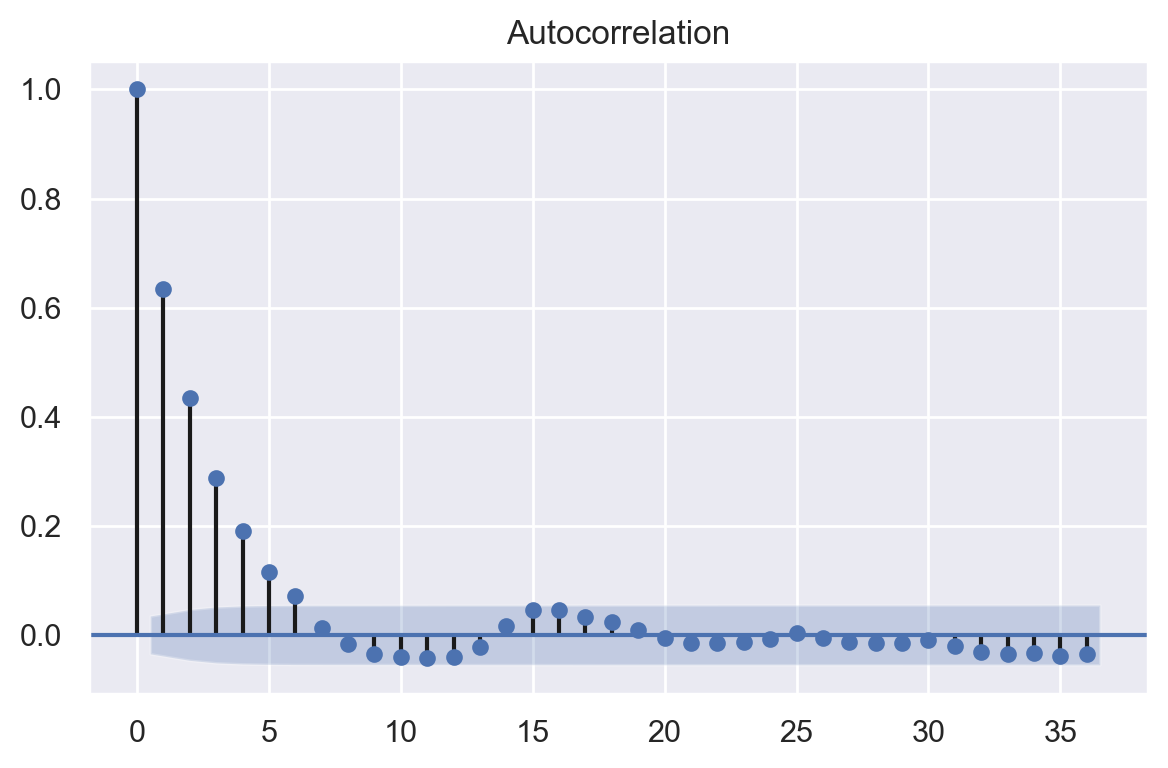

In [184]:
plot_acf(s)
plt.tight_layout()

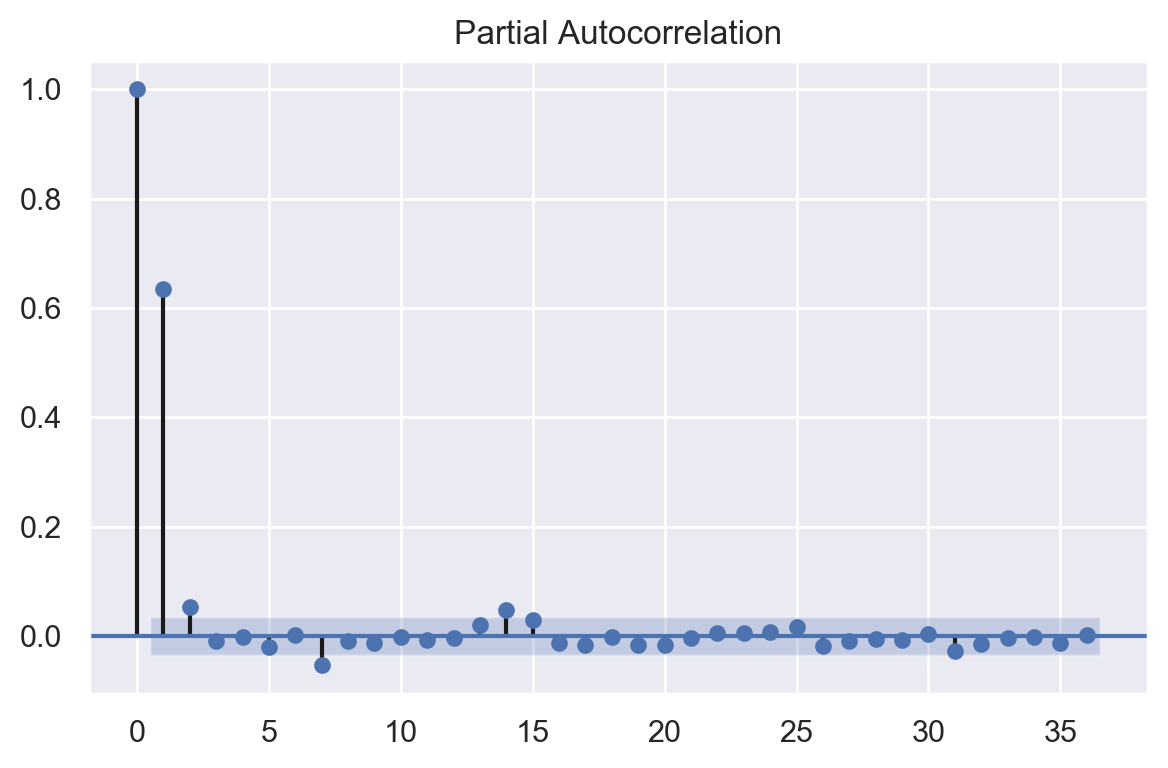

In [185]:
plot_pacf(s)
plt.tight_layout()

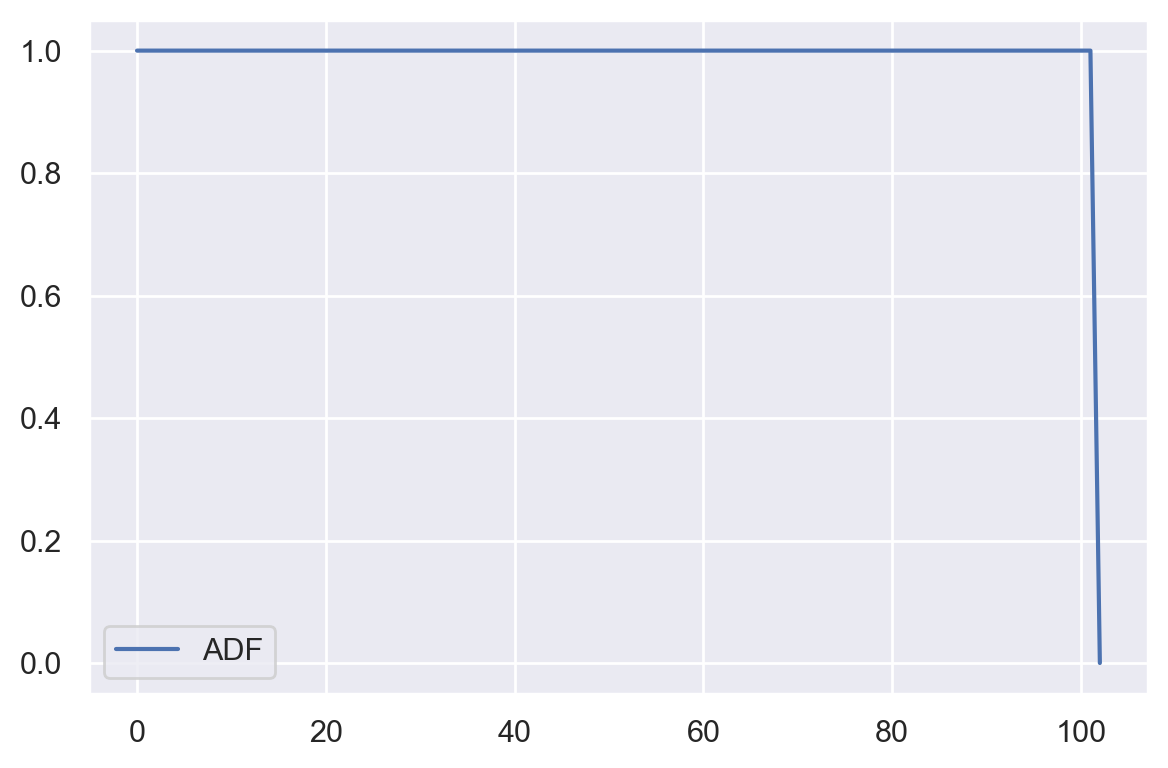

In [186]:
ax = sns.lineplot(data = adf)
plt.tight_layout()

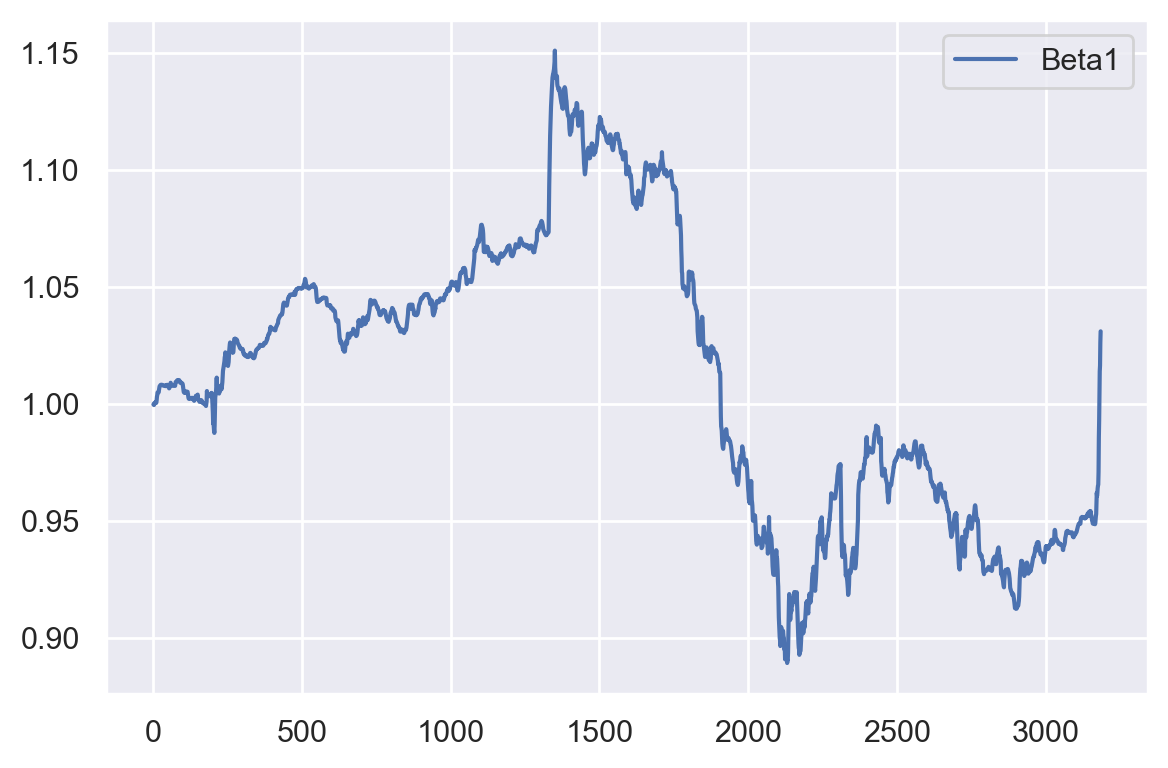

In [189]:
ax = sns.lineplot(data = beta1)
plt.tight_layout()

## Loop Pares

In [ ]:
c1 = 0
c2 = c1 + 1
acoes = list(df_prices.columns.values)

for c1 in range(len(acoes)-2): 

    acao1 = pd.DataFrame(df_log_prices.iloc[:, [c1]])
    acao2 = pd.DataFrame(df_log_prices.iloc[:, [c2]])
    
    res = spread(acao1, acao2, janela_dados, janela_desloc)
    s = res[0]
    adf = res[1]
    johansen = res[2]
    beta0 = res[3]
    beta1 = res[4]
    log_retornos = backtest(acao1, acao2, s, beta0, beta1, adf, janela_dados, janela_desloc, cost, th = 2)
    log_retornos.columns = [acao1.columns + "  vs  " + acao2.columns]
    
    if c1 == 0:
        matriz_log_retornos = log_retornos
    else:
        matriz_log_retornos = pd.concat([matriz_log_retornos, log_retornos], axis=1) 
    
    c1 +=2
    c2 = c1 + 1

In [ ]:
T = matriz_log_retornos.shape[0]
df_fundo_retorno = pd.DataFrame(data = np.zeros(T), index = np.arange(0,T), columns=['Fundo'])
i = 0
for i in np.arange(0, T):
    df_fundo_retorno.iloc[i,0] = np.nanmean(matriz_log_retornos[i,:])

In [ ]:
df_fundo_log_retorno = np.log(1+df_fundo_retorno)
df_fundo_log_retorno['Mes-Ano'] = df_fundo_log_retorno.index.astype(str).str[5:7] + '-' + df_fundo_log_retorno.index.astype(str).str[0:4] # coluna auxiliar para identificar mês e ano
df_fundo_log_retorno_mes = df_fundo_log_retorno.groupby(by = 'Mes-Ano', sort = False).sum()
df_fundo_log_retorno = df_fundo_log_retorno.drop(columns = 'Mes-Ano')
df_fundo_log_retorno_mes.columns = ['Fundo_Log_Retorno_Mes']
df_fundo_retorno_mes = np.exp(df_fundo_log_retorno_mes)-1
df_fundo_retorno_mes.columns = ['Fundo_Retorno_Mes']
print(df_fundo_retorno_mes)
print(df_fundo_log_retorno_mes)
df_fundo_retorno_exc = df_fundo_retorno - df_cdi_retorno
df_fundo_log_retorno_exc = np.log(1+df_fundo_retorno_exc)

In [38]:
T = 100
nomes_fundos = ['Fundo1', 'Fundo2']
df_fundo_retorno = pd.DataFrame(data = np.matrix([np.arange(0,T), np.arange(0,2*T,2)]).T, 
                                        index = np.arange(0,T), columns = nomes_fundos)
df_fundo_retorno.head()

,Fundo1,Fundo2
0,0,0
1,1,2
2,2,4
3,3,6
4,4,8


In [39]:
# Tabelas para guardar as estatísticas
n_fundos = 2
n_estat = 16
df_estat = pd.DataFrame(np.zeros([n_fundos, n_estat]), index = nomes_fundos, 
                        columns = ['Avg', 'DP', 'Min', 'Q1', 'Med', 'Q3', 'Max', 'Range', 
                                   'Skew', 'Kurt', '%_Pos', '%_Neg', '%_Pos_Mes', '%_Neg_Mes', '%_Exc_Pos', '%_Exc_Neg'])
print(df_estat)

        Avg   DP  Min   Q1  Med   Q3  Max  Range  Skew  Kurt  %_Pos  %_Neg  \
Fundo1  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   0.0   0.0    0.0    0.0   
Fundo2  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0   0.0   0.0    0.0    0.0   

        %_Pos_Mes  %_Neg_Mes  %_Exc_Pos  %_Exc_Neg  
Fundo1        0.0        0.0        0.0        0.0  
Fundo2        0.0        0.0        0.0        0.0  


In [46]:
# Principais estatísticas (retornos discretos diários)

i = 0
for nome_fundo in nomes_fundos:
    
    df_estat.iloc[i,0] = np.nanmean(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,1] = np.nanstd(np.array(df_fundo_retorno.iloc[:,i]), ddof = 1)
    df_estat.iloc[i,2] = np.min(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,3] = np.nanpercentile(np.array(df_fundo_retorno.iloc[:,i]), 25, axis = 0)
    df_estat.iloc[i,4] = np.nanpercentile(np.array(df_fundo_retorno.iloc[:,i]), 50, axis = 0)
    df_estat.iloc[i,5] = np.nanpercentile(np.array(df_fundo_retorno.iloc[:,i]), 75, axis = 0)
    df_estat.iloc[i,6] = np.max(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,7] = df_estat.iloc[i,6] - df_estat.iloc[i,2]
    df_estat.iloc[i,8] = sp.stats.skew(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,9] = sp.stats.kurtosis(np.array(df_fundo_retorno.iloc[:,i]))
    df_estat.iloc[i,10] = df_fundo_retorno.iloc[:,i][df_fundo_retorno.iloc[:,i]>0].count() / df_fundo_retorno.iloc[:,i].count()
    df_estat.iloc[i,11] = 1 - df_estat.iloc[i,10]
    # df_estat.iloc[i,12] = df_fundo_retorno_mes.iloc[:,i][df_fundo_retorno_mes.iloc[:,i]>0].count() / df_fundo_retorno_mes.iloc[:,i].count()
    # df_estat.iloc[i,13] = 1 - df_estat.iloc[i,12]
    # df_estat.iloc[i,14] = df_fundo_retorno_exc.iloc[:,i][df_fundo_retorno_exc.iloc[:,i]>0].count() / df_fundo_retorno_exc.iloc[:,i].count()
    # df_estat.iloc[i,15] = 1 - df_estat.iloc[i,14]
    
    i = i + 1
    
print(df_estat)

         Avg         DP  Min     Q1   Med      Q3    Max  Range  Skew  \
Fundo1  49.5  29.011492  0.0  24.75  49.5   74.25   99.0   99.0   0.0   
Fundo2  99.0  58.022984  0.0  49.50  99.0  148.50  198.0  198.0   0.0   

           Kurt  %_Pos  %_Neg  %_Pos_Mes  %_Neg_Mes  %_Exc_Pos  %_Exc_Neg  
Fundo1 -1.20024   0.99   0.01        0.0        0.0        0.0        0.0  
Fundo2 -1.20024   0.99   0.01        0.0        0.0        0.0        0.0  


In [ ]:
# Retornos acima e abaixo do Benchmark - Base Mensal
if str_tipo_fundo == 'Multimercado':
    df_fundo_retorno_exc_mes = pd.DataFrame(np.array(df_fundo_retorno_mes) - np.array(df_cdi_retorno_mes), 
                                        index = df_fundo_retorno_mes.index)

if str_tipo_fundo == 'Equity':
    df_fundo_retorno_exc_mes = pd.DataFrame(np.array(df_fundo_retorno_mes) - np.array(df_ibov_retorno_mes), 
                                        index = df_fundo_retorno_mes.index)

df_fundo_retorno_exc_mes.columns = ['Fundo_Retorno_Exc']
print(df_fundo_retorno_exc_mes)

fundo_pct_retornos_exc_mes_pos = df_fundo_retorno_exc_mes[df_fundo_retorno_exc_mes>0].count() / df_fundo_retorno_exc_mes.count()
fundo_pct_retornos_exc_mes_pos = np.array(fundo_pct_retornos_exc_mes_pos)
fundo_pct_retornos_exc_mes_neg = 1 - fundo_pct_retornos_exc_mes_pos
print('% Retornos Excedentes Positivos:')
print(fundo_pct_retornos_exc_mes_pos)
print('% Retornos Excedentes Negativos:')
print(fundo_pct_retornos_exc_mes_neg)

In [ ]:
# Melhor / Pior Dia
fundo_retorno_min = (np.min(np.array(df_fundo_retorno)))
print("Retorno Diário Mínimo:")
print(fundo_retorno_min)
dia_retorno_min = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_min].index)
print("Data de Ocorrência do Retorno Diário Mínimo:")
print(dia_retorno_min)

fundo_retorno_max = (np.max(np.array(df_fundo_retorno)))
print("Retorno Diário Máximo:")
print(fundo_retorno_max)
dia_retorno_max = np.array(df_fundo_retorno[df_fundo_retorno['Fundo_Retorno']==fundo_retorno_max].index)
print("Data de Ocorrência do Retorno Diário Máximo:")
print(dia_retorno_max)